# Simulation studies

(Move this notebook to the root directory to run it)

Note: For all these studies, the hyperparameter search has already been completed.

In [ ]:
import copy
import sys
from pathlib import Path
import yaml
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from coxkan import CoxKAN
from coxkan.utils import bootstrap_metric, set_seed

SEED = set_seed(42)

In [ ]:
### Reusable functions for the notebook

def true_cindex(df):
    global sim_config, duration_col, event_col, covariates
    lph = sim_config['log_partial_hazard'](**df[covariates])
    return concordance_index(df[duration_col], -lph, df[event_col])

def cph_cindex(df):
    global cph
    return cph.score(df, scoring_method='concordance_index')

def cph_formula(cph):
    coefficients = cph.params_
    terms = []
    for covariate, coefficient in coefficients.items():
        term = f"{coefficient:.4f} * {covariate}"
        terms.append(term)
    expression = " + ".join(terms)
    return expression

## Gaussian

For our first study, we set the log-partial hazard to be a Gaussian:

$$\theta(\mathbf{x}) = 5 \exp(-2 (x_1^2 + x_2^2))$$

In [ ]:
exp_name = "sim_gaussian"
sim_name = "gaussian"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

Evaluate performance of the 'true' expression. Clearly, the C-Index will not be perfect since survival time is randomly distributed.

In [ ]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

Evaluate Cox Proportional Hazards Model:

In [ ]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

Evaluate CoxKAN:

In [ ]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'],verbose=False)

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')


In [ ]:

fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png', dpi=600)

We can recognise these activation functions as `x^2, x^2, exp`. We try fitting these functions:

In [ ]:
formula = ckan.symbolic_formula()[0][0]
formula

The high $R^2$ values (coefficient of determination) verify that the true expression was learnt. However, the affine parameters are not quite correct (although a close approximation). We finish by training the affine params:

In [ ]:
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png', dpi=600)
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")

results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

## Shallow

In survival analysis, it is common that we encounter covariates that satisfy the linear Cox Proportional Hazards model after some non-linear transformation. In other words, they have non-linear relationships to the patient's risk but they do not interact. To simulate this situation we use the following expression for the log-partial hazard:

$$\theta(\mathbf{x}) = \tanh(5x_1) + \sin(2\pi x_2) + x_3^2$$

This can be captured by a shallow KAN (no hidden layers).

In [ ]:
exp_name = "sim_depth_1"
sim_name = "depth_1"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function
    
print(sim_config)

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

Evaluate true expression:

In [ ]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

Evaluate Cox proportional hazards model:

In [ ]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

CoxKAN:

In [ ]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'],verbose=False)

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png', bbox_inches='tight')
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png', bbox_inches='tight')

We can again recognise these activations: 
- some s-shaped function like `tanh` or `sigmoid`
- some oscillating function like `sin` (or `cos` but this is just a matter of affine parameters)
- a quadratic `x^2`

In the case of the s-shaped function we try out both options and see which is better:

In [ ]:

formula = ckan.symbolic_formula()[0][0]
print(f"Symbolic expression: {formula}")

The high $R^2$ values (coefficient of determination) verify that the true expression was learnt. On first glance, the `sin` term appears incorrect, but note that: $ - 0.96 \sin(6.27x + 12.58) \approx -\sin(2\pi x - 3\pi) = \sin(2\pi x)$

In [ ]:
_ = ckan.predict(df_test)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png', bbox_inches='tight')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")

results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}


## Deep

To contrast with the previous example, we now try an expression for the log-partial hazard that requires a deep KAN (2 hidden layers) to capture:

$$\theta(\mathbf{x}) = 2\sqrt{(x_1-x_2)^2 + (x_3-x_4)^2}$$

In [ ]:
exp_name = "sim_deep"
sim_name = "deep"

# load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

In [ ]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

In [ ]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

For this study (perhaps due to its difficulty), the hyperparameter search yielded early_stopping=True - hence we need to split the training set into a train and a validation set.

In [ ]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col=duration_col, event_col=event_col, **config['train_params'],prune_split=0.25)

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=20, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

Another benefit of using a validation set, is that we can use it to select a more optimal pruning threshold:

The affine parameters are not quite right. However, if we take some liberal approximations, we see that it has captured the true expression:

$ 3.97 \sqrt{0.96*(0.06 - x_2)^2 + 0.94*(0.09 - x_1)^2 + (-x_3 - 0.04)^2 + 0.79*(-x_4 - 0.04)^2 - 0.5*(-0.97*x_1 - x_2 + 0.14)^2 - 0.67*(-x_3 - 0.71*x_4 - 0.06)^2 + 0.56} $

$ \approx 4 \sqrt{x_2^2 + x_1^2 + x_3^2 + x_4^2 - \frac{1}{2}(x_1 + x_2)^2 - \frac{1}{2}(x_3 + x_4)^2} $

$ = 2 \sqrt{2x_1^2 + 2x_2^2 + 2x_3^2 + 2x_4^2 - (x_1 + x_2)^2 - (x_3 + x_4)^2} $

$ = 2 \sqrt{x_1^2 + x_2^2 - 2x_1x_2 + x_3^2 + x_4^2 - 2x_3x_4}$

$ = 2 \sqrt{(x_1 - x_2)^2 + (x_3 - x_4)^2}$

Obviously, in the case of a real dataset, we would not be able to make these reckless approximations, nor would we necessarily go through spotting all these activations as their 'true' symbolic counterparts. In the next example, we will see an example where we instead just call `auto_symbolic` rather than recognising activations by eye. 

## Intentionally difficult dataset

Next we use an expression for the log-partial hazard which is intentionally difficult to capture.

$$\theta(\mathbf{x}) = \tanh(5(\log(x_1) + |x_2|))$$

The intuitition behind this choice is that
- $\tanh(5z)$ has a very shallow gradient in much of its domain, hence there will not be much of a training signal when comparing subjects in these regions.
- $|x_2|$ is non-smooth. KAN activations use B-Splines which are necessarily smooth - thus this activation is likely to be difficult to learn. 

In [ ]:
exp_name = "sim_difficult"
sim_name = "difficult"

# load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

In [ ]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

In [ ]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

In [ ]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

Surprisingly, the `tanh` activation was recovered, and the symbolic fitting actually smoothed out some of the noisy bumps, yielding a better result. Unforunately, the other activations were not recovered. 

However, the C-Index is very close to that of the true expression, suggesting that our expression is a close approximation in the relevant domain. We now plot the true and predicted expressions:

In [ ]:
import torch 
import numpy as np

x1_range=(0.1, 1)
x2_range=(-1, 1)

# create grid of x1 and x2 values
x1 = np.linspace(*x1_range, 100)
x2 = np.linspace(*x2_range, 100)
X = np.meshgrid(x1, x2)
X = np.array(X).reshape(2, -1).T
X = torch.tensor(X, dtype=torch.float64)

# add noise
X = torch.cat([X, torch.zeros_like(X)[:, :2]], dim=1)

# get the predicted log partial hazard
lph_true = sim_config['log_partial_hazard'](X[:,0], X[:,1], *X[:,2:].T)

with torch.no_grad():
    lph_pred = ckan(X)
lph_pred = lph_pred.detach().numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot the true log partial hazard
levels = np.linspace(lph_true.min(), lph_true.max(), 100)
contour = axes[0].tricontourf(X[:,0], X[:,1], lph_true, levels=levels, cmap='coolwarm')
axes[0].set_xlabel(r'$x_1$', fontsize=14)
axes[0].set_ylabel(r'$x_2$', fontsize=14)
axes[0].set_xticks(x1_range)
axes[0].set_yticks(x2_range)

# plot the predicted log partial hazard
levels = np.linspace(lph_pred.min(), lph_pred.max(), 100)
contour = axes[1].tricontourf(X[:,0], X[:,1], lph_pred, levels=levels, cmap='coolwarm')
axes[1].set_xlabel(r'$x_1$', fontsize=14)
axes[1].set_ylabel(r'$x_2$', fontsize=14)
axes[1].set_xticks(x1_range)
axes[1].set_yticks(x2_range)

axes[0].text(0.02, 1.05, r'(a) True $\theta(\mathbf{x})$', fontsize=17, transform=axes[0].transAxes)
axes[1].text(0.02, 1.05, r'(b) CoxKAN Symbolic $\hat{\theta}(\mathbf{x})$', fontsize=17, transform=axes[1].transAxes)

fig.savefig(f'checkpoints/{exp_name}/lph_surfaces.png')

We see that indeed, the predicted expression is a very close approximation to the truth. 

I argue that CoxKAN still has the properties of high performance and interpretability in this case.

In [ ]:
results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_pre': cindex_pre,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

## Reviewer Suggested Functions to Investigate

### Linear Func

In [ ]:
import copy
import sys
from pathlib import Path
import yaml
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from coxkan import CoxKAN
from coxkan.utils import bootstrap_metric, set_seed

SEED = set_seed(42)

### Reusable functions for the notebook

def true_cindex(df):
    global sim_config, duration_col, event_col, covariates
    lph = sim_config['log_partial_hazard'](**df[covariates])
    return concordance_index(df[duration_col], -lph, df[event_col])

def cph_cindex(df):
    global cph
    return cph.score(df, scoring_method='concordance_index')

def cph_formula(cph):
    coefficients = cph.params_
    terms = []
    for covariate, coefficient in coefficients.items():
        term = f"{coefficient:.4f} * {covariate}"
        terms.append(term)
    expression = " + ".join(terms)
    return expression
exp_name = "sim_reviewer_1_2"
sim_name = "reviewer_1_2"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

# CoxKAN
ckan_trained = CoxKAN(seed=42, **config['init_params'])
log = ckan_trained.train(df_train, df_test, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan_trained.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan_trained.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')
# search for pruning thresholds

_ = ckan_trained.predict(df_test)
fig = ckan_trained.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")
formula = ckan_trained.symbolic_formula()[0][0]
formula


In [ ]:

#plot x1, x2 with survival as color in test data AND by inputting the test data into the symbolic expression
# have it be two-plot wide subplots

import matplotlib.pyplot as plt
import numpy as np

test_x1 = df_test['x1'].values
test_x2 = df_test['x2'].values
test_x3 = df_test['x3'].values
test_x4 = df_test['x4'].values
test_surv = df_test['duration'].values
test_lph = sim_config['log_partial_hazard'](test_x1, test_x2, test_x3, test_x4)
print(test_lph)

pred_lph = ckan_trained.predict(df_test)
print(pred_lph)

# Create a scatter plot of x1 and x2 with survival time as color
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(test_x1, test_x2, c=test_lph, cmap='viridis', alpha=0.7)
plt.colorbar(label='Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Data Survival Time')
plt.subplot(1, 3, 2)
plt.scatter(test_x1, test_x2, c=pred_lph, cmap='viridis', alpha=0.7)
plt.colorbar(label='Predicted Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Survival Time')
plt.subplot(1, 3, 3)
plt.scatter(test_x1, test_x2, c=pred_lph-test_lph, cmap='viridis', alpha=0.7)
plt.colorbar(label='Log Partial Hazard Difference')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Difference in Survival Time')
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/pred_surv.png')
plt.show()

## Add plot of x1 vs residual (i.e., diff between predicted and true log partial hazard) and same for x2
# add in statistics like: correlation


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_x1, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x1')
plt.ylabel('Residual')
plt.title('Residual vs x1')
# add in correlation coefficient
corr_x1 = np.corrcoef(test_x1, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x1:.2f}', transform=plt.gca().transAxes)
plt.subplot(1, 2, 2)
plt.scatter(test_x2, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x2')
plt.ylabel('Residual')
plt.title('Residual vs x2')
corr_x2 = np.corrcoef(test_x2, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x2:.2f}', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/residuals_reviewer_1_2.png')
plt.show()

### Linear without regularisation

True log partial hazard: x1 + np.sin(2 * np.pi * x2)
True C-Index: 0.717955 (0.718, 0.720)
CoxPH Expression: 0.7413 * x1 + -0.4011 * x2 + -0.0342 * x3 + 0.0090 * x4
CoxPH C-Index: 0.653177 (0.653, 0.656)


train loss: 2.73e+00 | val loss: 2.53e+00: 100%|████████████████| 1000/1000 [30:22<00:00,  1.82s/it]


Training finished. Final Training C-index: 0.725
Pre-pruned Validation C-index: 0.711
Pruned Validation C-index: 0.711
Symbolic Validation C-index: 0.712
Pre-symbolic: 0.712465 (0.712, 0.715)
Saved model to checkpoints/sim_reviewer_1_2/model.pt
Layer 0: 4
Layer 1: 4
Layer 2: 1
Symbolic: 0.712465 (0.712, 0.714)


0.176106063548358*sqrt(1 - x4) - 0.454928276159364*sigmoid(1.928 - 7.0*x1) + 0.573340049340783*sigmoid(-8.43084096908569*sigmoid(1.2 - 10.0*x1) + 3.82051259279251*sin(4.8584*x2 + 6.21952) - 2.91122555732727*sin(4.14896*x4 + 5.40944) + 8.42902372330427 - 6.4195191860199*exp(-26.2144*(-x3 - 0.649671875)**2)) + 0.518460924149943*sigmoid(2.10446178913116*sin(4.86216*x1 - 4.00864) + 3.37813198566437*sin(6.43104*x2 - 0.00288000000000001) - 3.2125704228878 + 2.32253894209862*exp(-2.5237770496*(-0.939822741464397*x4 - 1)**2) + 2.59913712739944*exp(-1.44*(0.38 - x3)**2)) - 3.02308207202202*log(-0.943924590873718*x1 - 0.818030469379425*sigmoid(-7.8672*x3 - 0.716079999999999) - 0.724844462547302*sigmoid(10.0*x4 - 2.6) + 0.528374484939575*sin(6.36952*x2 - 9.39184) + 8.41033492297623) - 0.534265223554983*sin(6.37848*x2 - 3.19152) - 0.325328619344135*exp(-52.243984*(-0.968456004427227*x3 - 1)**2)

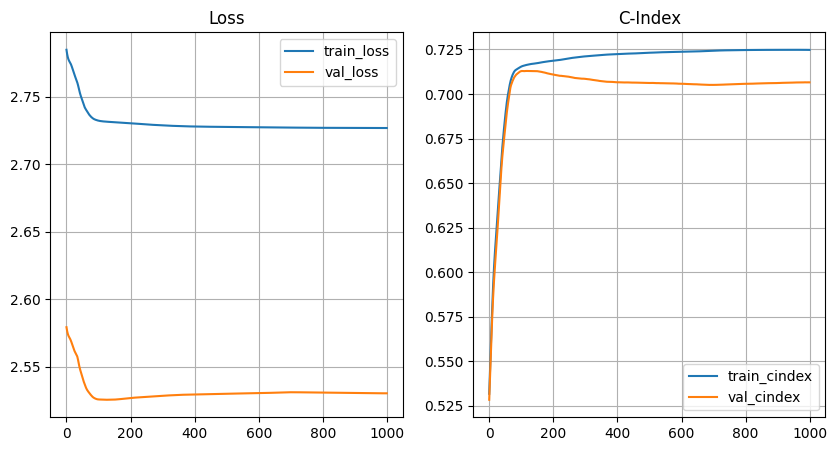

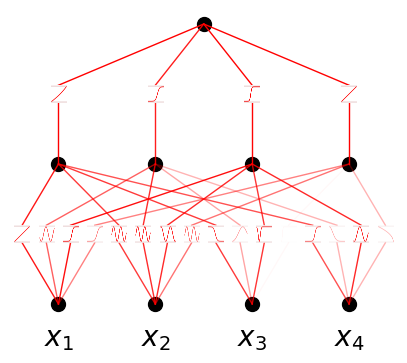

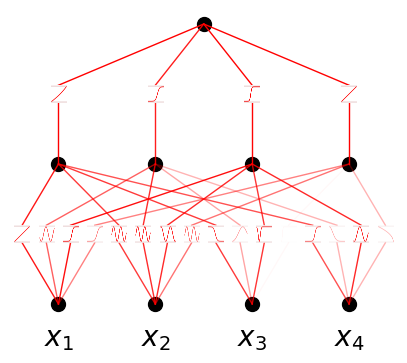

In [1]:
import copy
import sys
from pathlib import Path
import yaml
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from coxkan import CoxKAN
from coxkan.utils import bootstrap_metric, set_seed

SEED = set_seed(42)

### Reusable functions for the notebook

def true_cindex(df):
    global sim_config, duration_col, event_col, covariates
    lph = sim_config['log_partial_hazard'](**df[covariates])
    return concordance_index(df[duration_col], -lph, df[event_col])

def cph_cindex(df):
    global cph
    return cph.score(df, scoring_method='concordance_index')

def cph_formula(cph):
    coefficients = cph.params_
    terms = []
    for covariate, coefficient in coefficients.items():
        term = f"{coefficient:.4f} * {covariate}"
        terms.append(term)
    expression = " + ".join(terms)
    return expression
exp_name = "sim_reviewer_1_2"
sim_name = "reviewer_1_2"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

# CoxKAN
ckan_trained = CoxKAN(seed=42, **config['init_params'])

# turn off regularisation
for k, v in config['train_params'].items():
    if 'lamb' in k:
        config['train_params'][k] = 0
        
#set  early_stopping to False and steps to 1000
config['train_params']['early_stopping'] = False
config['train_params']['steps'] = 1000
        
# also set the following params in train to 0: small_reg_factor
log = ckan_trained.train(df_train, df_test, duration_col, event_col, **config['train_params'],small_reg_factor=0,
                        do_reg=False)

cindex_pre = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan_trained.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan_trained.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

for i, w in enumerate(ckan_trained.width):
    print(f"Layer {i}: {w}")
    
_ = ckan_trained.predict(df_test)
fig = ckan_trained.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")
formula = ckan_trained.symbolic_formula()[0][0]
formula

Symbolic expression: 0.176106063548358*sqrt(1 - x4) - 0.454928276159364*sigmoid(1.928 - 7.0*x1) + 0.573340049340783*sigmoid(-8.43084096908569*sigmoid(1.2 - 10.0*x1) + 3.82051259279251*sin(4.8584*x2 + 6.21952) - 2.91122555732727*sin(4.14896*x4 + 5.40944) + 8.42902372330427 - 6.4195191860199*exp(-26.2144*(-x3 - 0.649671875)**2)) + 0.518460924149943*sigmoid(2.10446178913116*sin(4.86216*x1 - 4.00864) + 3.37813198566437*sin(6.43104*x2 - 0.00288000000000001) - 3.2125704228878 + 2.32253894209862*exp(-2.5237770496*(-0.939822741464397*x4 - 1)**2) + 2.59913712739944*exp(-1.44*(0.38 - x3)**2)) - 3.02308207202202*log(-0.943924590873718*x1 - 0.818030469379425*sigmoid(-7.8672*x3 - 0.716079999999999) - 0.724844462547302*sigmoid(10.0*x4 - 2.6) + 0.528374484939575*sin(6.36952*x2 - 9.39184) + 8.41033492297623) - 0.534265223554983*sin(6.37848*x2 - 3.19152) - 0.325328619344135*exp(-52.243984*(-0.968456004427227*x3 - 1)**2)
[ 1.07811192 -0.01998724 -0.11658097 ...  1.23009515 -1.13966914
  0.07480486]
0   

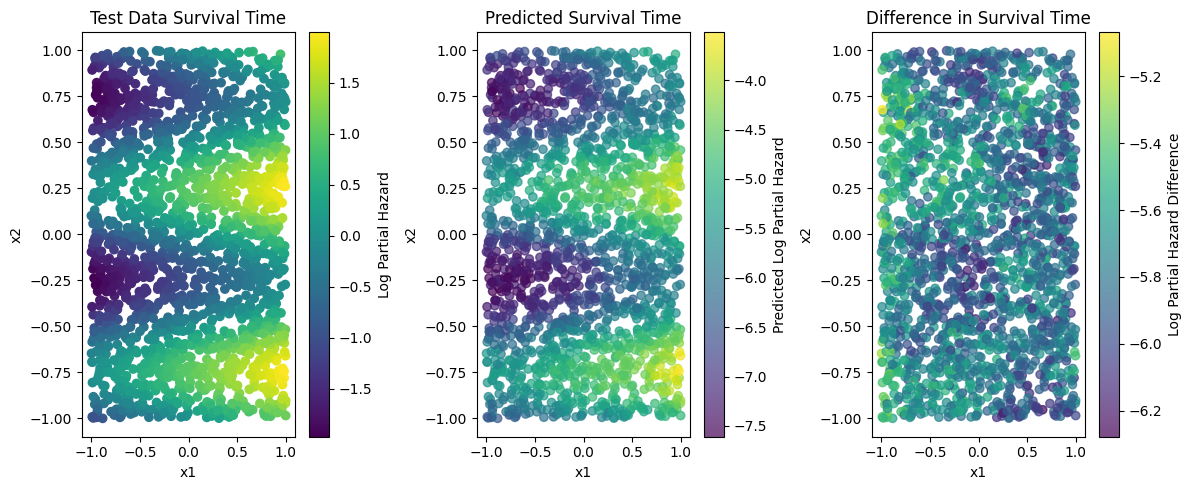

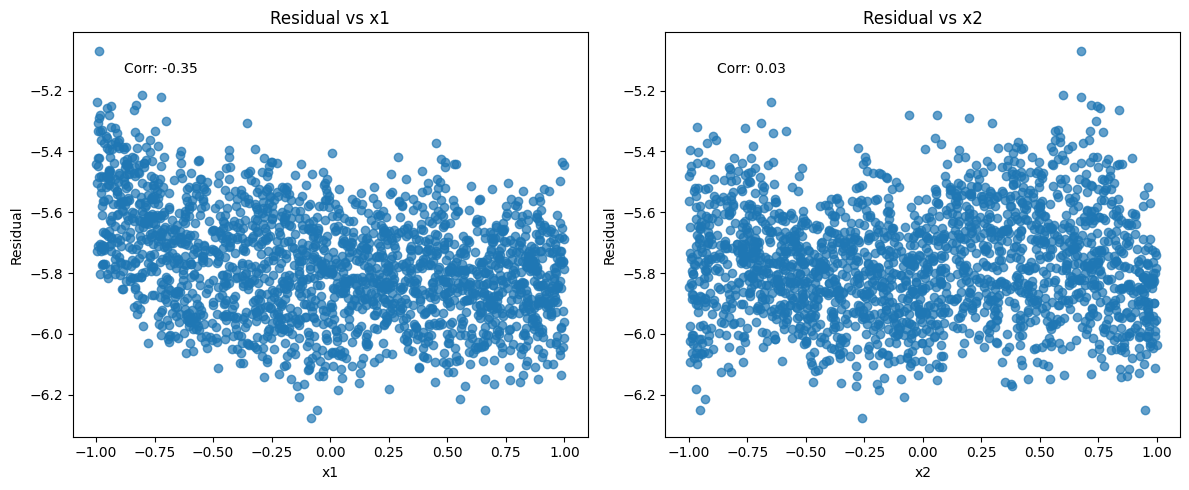

In [2]:
# print formula
print(f"Symbolic expression: {formula}")

#plot x1, x2 with survival as color in test data AND by inputting the test data into the symbolic expression
# have it be two-plot wide subplots

import matplotlib.pyplot as plt
import numpy as np

test_x1 = df_test['x1'].values
test_x2 = df_test['x2'].values
test_x3 = df_test['x3'].values
test_x4 = df_test['x4'].values
test_surv = df_test['duration'].values
test_lph = sim_config['log_partial_hazard'](test_x1, test_x2, test_x3, test_x4)
print(test_lph)

pred_lph = ckan_trained.predict(df_test)
print(pred_lph)

# Create a scatter plot of x1 and x2 with survival time as color
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(test_x1, test_x2, c=test_lph, cmap='viridis')
plt.colorbar(label='Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Data Survival Time')
plt.subplot(1, 3, 2)
plt.scatter(test_x1, test_x2, c=pred_lph, cmap='viridis', alpha=0.7)
plt.colorbar(label='Predicted Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Survival Time')
plt.subplot(1, 3, 3)
plt.scatter(test_x1, test_x2, c=pred_lph-test_lph, cmap='viridis', alpha=0.7)
plt.colorbar(label='Log Partial Hazard Difference')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Difference in Survival Time')
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/pred_surv.png')
plt.show()


## Add plot of x1 vs residual (i.e., diff between predicted and true log partial hazard) and same for x2
# add in statistics like: correlation


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_x1, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x1')
plt.ylabel('Residual')
plt.title('Residual vs x1')
# add in correlation coefficient
corr_x1 = np.corrcoef(test_x1, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x1:.2f}', transform=plt.gca().transAxes)
plt.subplot(1, 2, 2)
plt.scatter(test_x2, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x2')
plt.ylabel('Residual')
plt.title('Residual vs x2')
corr_x2 = np.corrcoef(test_x2, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x2:.2f}', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/residuals_reviewer_1_2.png')
plt.show()

### Quadratic

In [ ]:
exp_name = "sim_reviewer_1_3"
sim_name = "reviewer_1_3"
# load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function
    
# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)
    
# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

In [ ]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']
print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

In [ ]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

In [ ]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])
log = ckan.train(df_train, df_test, duration_col=duration_col, event_col=event_col, **config['train_params'])
cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")
# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

In [ ]:
# search for pruning thresholds
pruning_thresholds = np.linspace(0, 0.05, 20)
pruning_thresholds[0] = config['prune_threshold']
cindices = []
for threshold in pruning_thresholds:
    ckan_ = CoxKAN(seed=42, **config['init_params'])
    ckan_.load_ckpt(f'checkpoints/{exp_name}/model.pt', verbose=False)
    _ = ckan_.predict(df_test) # important forward pass after loading a model
    
    prunable = True
    for l in range(ckan_.depth):
        if not (ckan_.acts_scale[l] > threshold).any():
            prunable = False
            break
        
    ckan_ = ckan_.prune_nodes(threshold)
    if 0 in ckan_.width: prunable = False
    if not prunable:
        if threshold == config['prune_threshold']: 
            cindices.append(0)
            continue
        else: break

    _ = ckan_.predict(df_test) # important forward pass
    print(_.mean())
    ckan_.prune_edges(threshold, verbose=False)
    cindices.append(ckan_.cindex(val))
    print(f'Pruning threshold: {threshold:.2f}, C-Index (Val): {cindices[-1]:.6f}')
max_cindex = np.max(cindices)
best_threshold = np.max(pruning_thresholds[cindices == max_cindex])
if np.max(cindices) < 0.51: best_threshold = 0

In [ ]:
# print width of each layer and layer index
for i, w in enumerate(ckan.width):
    print(f"Layer {i}: {w}")
    
# Pruning
_ = ckan.predict(df_test)
print(_)
print(_.mean())
ckan.prune_edges(best_threshold, verbose=True)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pruned.png')
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pruned: {cindex_pruned}")

In [ ]:
_ = ckan.auto_symbolic(verbose=True)
_ = ckan.predict(df_test)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$x_4$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")
formula = ckan.symbolic_formula()[0][0]
formula

In [ ]:
#plot x1, x2 with survival as color in test data AND by inputting the test data into the symbolic expression
# have it be two-plot wide subplots

import matplotlib.pyplot as plt
import numpy as np
test_x1 = df_test['x1'].values
test_x2 = df_test['x2'].values
test_x3 = df_test['x3'].values
test_x4 = df_test['x4'].values

test_surv = df_test['duration'].values
test_lph = sim_config['log_partial_hazard'](test_x1, test_x2, test_x3, test_x4)
print(test_lph)
pred_lph = ckan.predict(df_test)
print(pred_lph)
# Create a scatter plot of x1 and x2 with survival time as color
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(test_x1, test_x2, c=test_lph, cmap='viridis', alpha=0.7,vmin=0, vmax=6)
plt.colorbar(label='Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Data Survival Time')
plt.subplot(1, 3, 2)
plt.scatter(test_x1, test_x2, c=pred_lph, cmap='viridis', alpha=0.7,vmin=0, vmax=6)
plt.colorbar(label='Predicted Log Partial Hazard')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Survival Time')
plt.subplot(1, 3, 3)
plt.scatter(test_x1, test_x2, c=pred_lph-test_lph, cmap='viridis', alpha=0.7,vmin=0, vmax=6)
plt.colorbar(label='Log Partial Hazard Difference')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Difference in Survival Time')
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/pred_surv.png')
plt.show()

In [ ]:
## Add plot of x1 vs residual (i.e., diff between predicted and true log partial hazard) and same for x2
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_x1, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x1')
plt.ylabel('Residual')
plt.title('Residual vs x1')
# add in correlation coefficient
corr_x1 = np.corrcoef(test_x1, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x1:.2f}', transform=plt.gca().transAxes)
plt.subplot(1, 2, 2)
plt.scatter(test_x2, pred_lph-test_lph, alpha=0.7)
plt.xlabel('x2')
plt.ylabel('Residual')
plt.title('Residual vs x2')
corr_x2 = np.corrcoef(test_x2, pred_lph-test_lph)[0, 1]
plt.text(0.1, 0.9, f'Corr: {corr_x2:.2f}', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig(f'checkpoints/{exp_name}/residuals_reviewer_1_3.png')
plt.show()